# ACOM Tutorial - Simulated Nanoparticle Au

This notebook demonstates automated crystal orientation mapping (ACOM) mapping of a simulated 4D-STEM dataset of a nanocrystalline Au sample.

## Data
This is a simulated 4D-STEM dataset.  Simulations were performed by Colin Ophus, have DOI number 10.5281/zenodo.3592520, and can be [downloaded here](https://drive.google.com/file/d/1QiH7phMR0AaMkYoio3uhgTTQMOHG4l6b/view?usp=sharing).  
You should then set the `filepath` variable in the cell below.

## Acknowlegements

This tutorial was made by Colin Ophus, Steven Zeltmann, and Benjamin Savitzky. Contact clophus@lbl.gov with any questions.

### Versioning

Last updated on 2022-01-13 with py4DSTEM v.0.12.10

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import py4DSTEM

In [6]:
py4DSTEM.__version__

'0.12.10'

If you are running in binder run the cell below, otherwise skip

In [34]:
# from py4DSTEM.io import download_file_from_google_drive
# download_file_from_google_drive("1QiH7phMR0AaMkYoio3uhgTTQMOHG4l6b", "/home/jovyan/data/calibrationData_simulatedAuNanoplatelet_binned.h5")

In [35]:
# Note - change the file path to your own local path
# filepath = "calibrationData_simulatedAuNanoplatelet_binned.h5"
# filepath = '/media/cophus/DATA/4DSTEM/datasets/calibrationData_simulatedAuNanoplatelet_binned.h5'
# filepath = 'C:/data/4DSTEM/datasets/calibrationData_simulatedAuNanoplatelet_binned.h5'
filepath = '/home/jovyan/data/calibrationData_simulatedAuNanoplatelet_binned.h5'

# Load the data

In [36]:
# Check the file contents
py4DSTEM.io.read(filepath)

py4DSTEM file version 0.11.10
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (100, 84, 125, 125)     polyAu_4DSTEM                                         
  1       DataCube          (100, 84, 125, 125)     simulation_4DSTEM                                     
  2       DiffractionSlice  (512, 512)              defocused_probe                                       
  3       DiffractionSlice  (125, 125)              probe_template                                        


### What this data is

The data here is meant to represent everything needed to perform the calibrations required for strain mapping.  The data in which strain is to be measuremed and analyzed is not required at this point.  The idea is that for a single day of experiments and a single set of experimental conditions, these calibrations need only be performed once.  The output file of this notebook can then be used to calibrate and analyze many 4D-STEM datasets.

#### `datacube_cal` (polyAu_4DSTEM)

This is a 4D-STEM scan of a calibartion sample - ideally, this should be a sample with known structure / lattice parameters, and with many crystal orientations represented.  Here we use a polydisperse distribution of gold nanoparticles.  The collection of many rotation angles of a crystal of known lattice structure is useful for calibration of the diffraction space pixel size, as well as the elliptical distortions.

This is the dataset we will use for learning the ACOM module.

#### `probe_template`

py4DSTEM detects Bragg scattering using template matching - to use these methods, an image of the probe template should be collected. Bragg disk detection is used here for careful elliptical distortion measurement.

#### `defocused_probe` and `datacube_rotation` (simulation_4DSTEM)

The real and diffraction planes may, in general, have some rotational misalignment.  Here we determine this misalignment by measuring the rotation between two images of the same sample - one in the diffraction plane, and one in the real plane.  A diffraction plane image can be obtained by defocusing the beam will produce a shadow image of the sample inside the CBED pattern.  A real plane image can be obtained using any STEM imaging modality.  Here we used an image of the defocused probe and a virtual image generated from a 4D-STEM scan, both obtained with the beam incident on the same sample, to perform this calibration.

In [37]:
# load the data
datacube = py4DSTEM.io.read(filepath,data_id='polyAu_4DSTEM')
probe_template = py4DSTEM.io.read(filepath,data_id='probe_template').data
defocused_probe = py4DSTEM.io.read(filepath,data_id='defocused_probe').data
datacube_rotation = py4DSTEM.io.read(filepath,data_id='simulation_4DSTEM')

In [38]:
coordinates = py4DSTEM.io.datastructure.Coordinates(
    datacube.R_Nx,
    datacube.R_Ny,
    datacube.Q_Nx,
    datacube.Q_Nx,
    name='coordinates_poly_Au')

# Visualize the Data

In [39]:
datacube.data.shape

(100, 84, 125, 125)

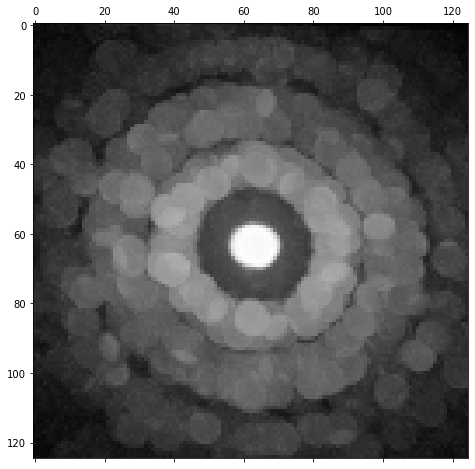

In [40]:
# Examine the 4D calibration dataset by taking a maximum diffraction pattern
dp_max = np.max(datacube.data,axis=(0,1))
py4DSTEM.visualize.show(dp_max,scaling='log')

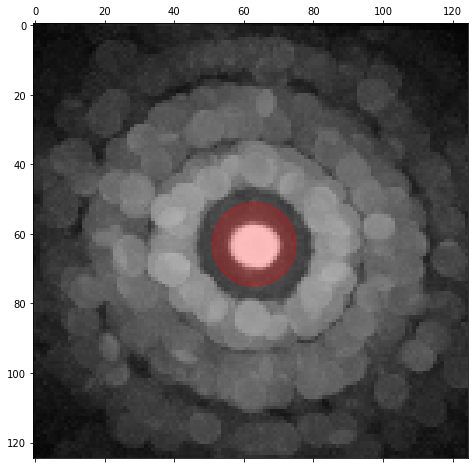

100%|███████████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 101732.65it/s]


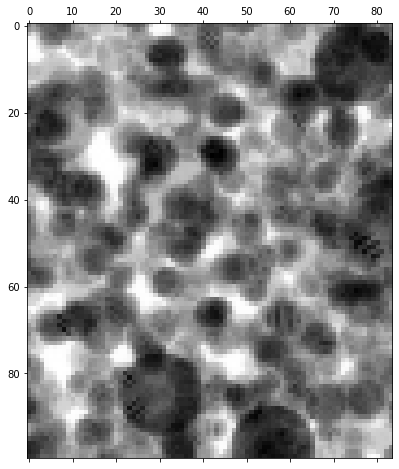

In [41]:
# Bright-field image
qx0,qy0 = 63,63
qR = 12

py4DSTEM.visualize.show_circles(dp_max,center=(qx0,qy0),R=qR,alpha=0.25,scaling='log')
BF = py4DSTEM.process.virtualimage.get_virtualimage(datacube,((qx0,qy0),qR))
py4DSTEM.visualize.show(BF)

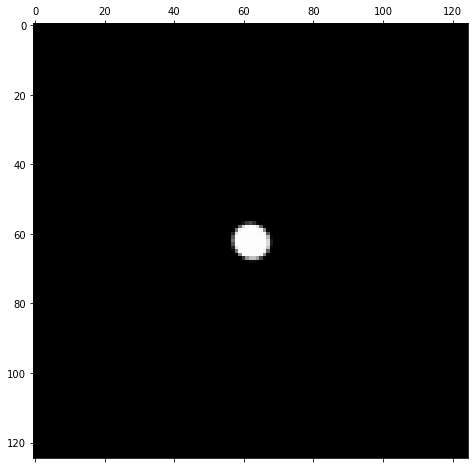

In [42]:
# Probe template
py4DSTEM.visualize.show(probe_template)

# Find the Origin in Diffraction Space

Here we:
- measure the position of the origin 
- mask any outlier positions 
- fit a plane to those positions
- set the fit plane as the origin of coordinates at each scan position

Finding origins: 100%|██████████████████████████████████████████████████████████████| 8.40k/8.40k [00:11<00:00, 749DP/s]


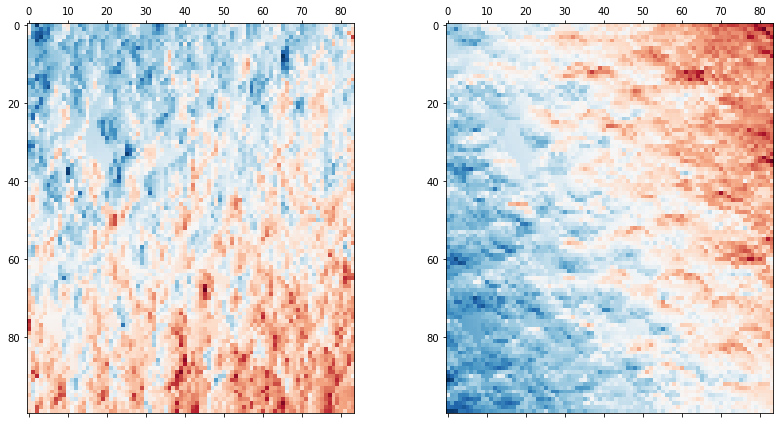

In [43]:
# Find CoM of center disk
qx0_meas,qy0_meas = py4DSTEM.process.calibration.get_origin(datacube=datacube)
py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:[qx0_meas,qy0_meas][i],
    H=1,W=2,cmap='RdBu')

Note how the qx0 and qy0 diffraction shifts both change as a function of probe position x and y - this is diffraction shift, or "descan" of the diffraction space images.

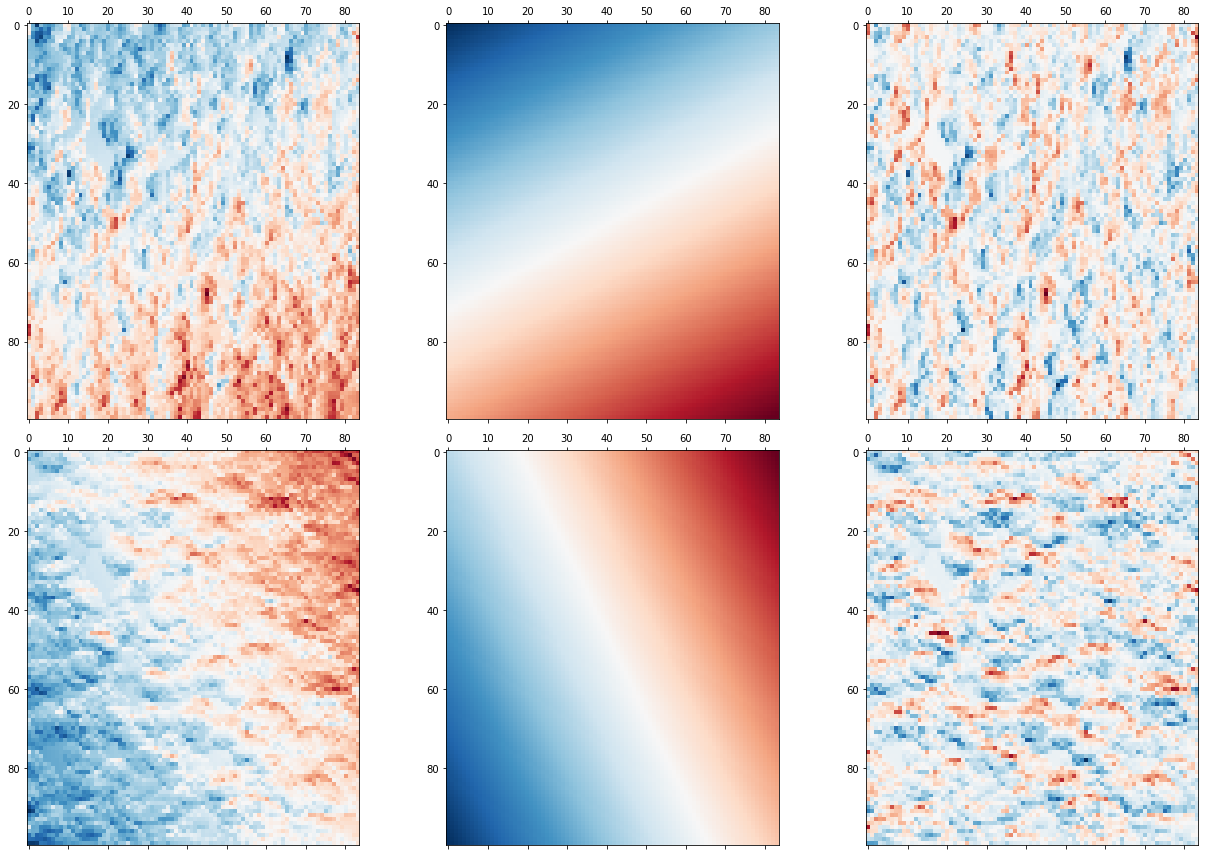

In [44]:
# Fit a plane to qx0 and qy0 with robust fitting
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = py4DSTEM.process.calibration.fit_origin(
    qx0_meas,
    qy0_meas,
    fitfunction='plane',
    robust=True)
py4DSTEM.visualize.show_image_grid(
    lambda i:[qx0_meas,qx0_fit,qx0_residuals,
              qy0_meas,qy0_fit,qy0_residuals][i],
    H=2,W=3,cmap='RdBu')

In [45]:
# Store the origin position
coordinates.set_origin(qx0_fit,qy0_fit)

# Prepare the probe template

Here we
- measure the center position and radius of the probe image
- generate a probe kernel for the template-matching disk detection step

Creating a good probe kernel is *essential* for the disk detection algorithm to work well - tuning the parameters you pass to `find_Bragg_disks` won't do you a lick of good if your kernel is no good.  More discussion of what makes a good probe template, and how to generate one, coming soon to a demo notebook near you.

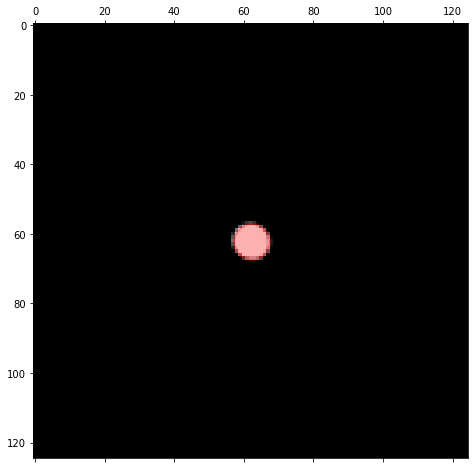

In [46]:
# Estimate the probe radius and position
qr,qx0,qy0 = py4DSTEM.process.calibration.get_probe_size(probe_template)
py4DSTEM.visualize.show_circles(
    probe_template,
    (qx0,qy0),
    qr)

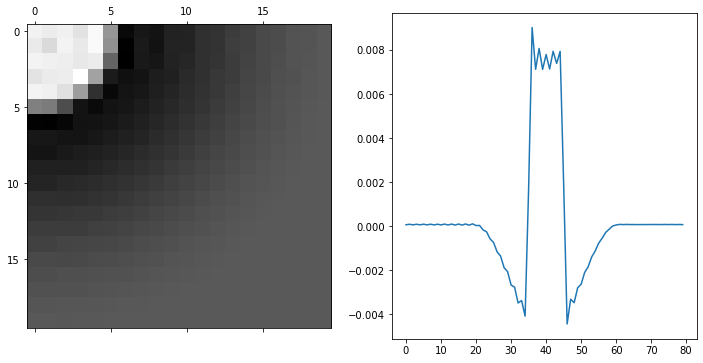

In [47]:
# Make a probe kernel for disk-finding
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(                            
    probe_template,
    qr*0.0,
    qr*4.0,
    origin=(qx0,qy0))
py4DSTEM.visualize.show_kernel(probe_kernel,R=20,L=40,W=2)

# Find bragg disk positions

Here, we
- select a few diffraction patterns to use as examples
- tune the disk fitting parameters
- perform the disk fitting
- center the detected disk positions
- compute the bragg vector map (a 2D binned histogram of bragg peak positions and intensities)

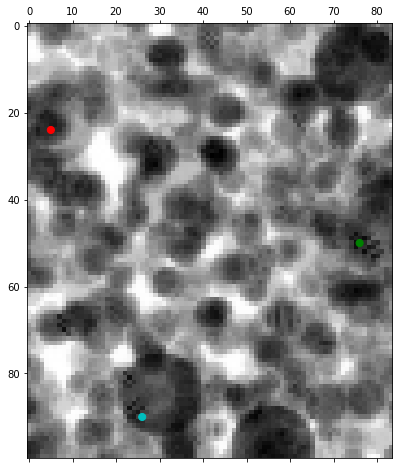

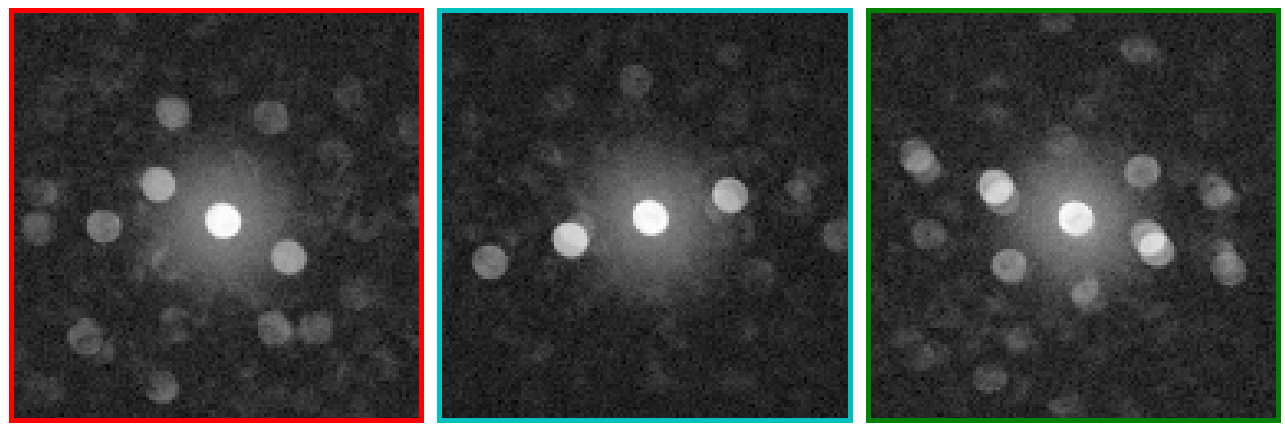

In [48]:
# Select a few DPs on which to test disk detection parameters
rxs_cal = 24,90,50
rys_cal = 5,26,76
colors = ['r','c','g']

py4DSTEM.visualize.show_points(BF,x=rxs_cal,y=rys_cal,pointcolor=colors,figsize=(8,8))
py4DSTEM.visualize.show_image_grid(get_ar=lambda i:datacube.data[rxs_cal[i],rys_cal[i],:,:],
                                   H=1,W=3,get_bordercolor=lambda i:colors[i],scaling='log')

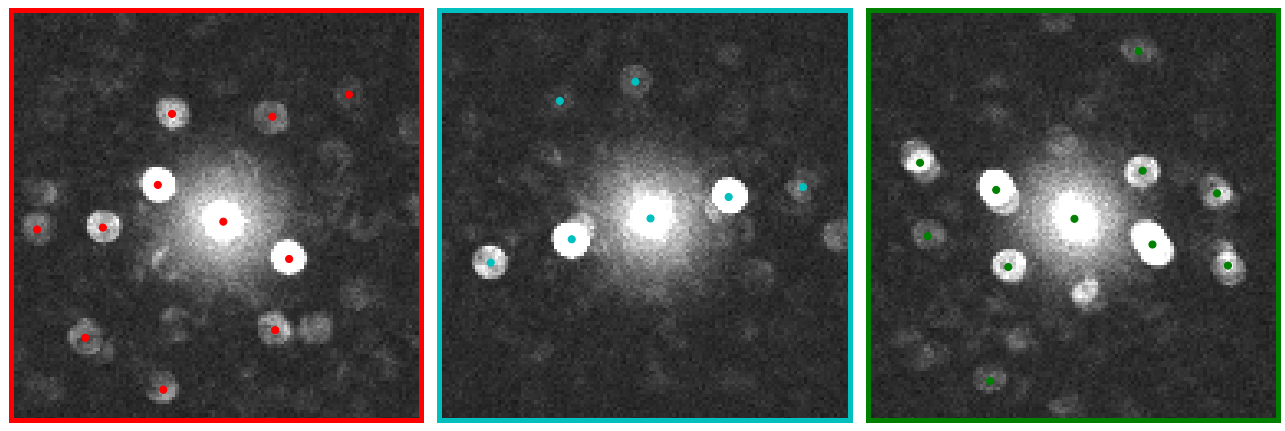

In [49]:
# Tune disk detection parameters on selected DPs
corrPower=1.0
sigma=1
edgeBoundary=4
minAbsoluteIntensity=15.0
minRelativeIntensity=0.0
minPeakSpacing=8
maxNumPeaks=100
subpixel='poly'
upsample_factor=16


selected_peaks = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(        
    datacube=datacube,
    probe=probe_kernel,
    Rx=rxs_cal,
    Ry=rys_cal,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minAbsoluteIntensity=minAbsoluteIntensity,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor
)

py4DSTEM.visualize.show_image_grid(
    get_ar=lambda i:datacube.data[rxs_cal[i],rys_cal[i],:,:],H=1,W=3,
    get_bordercolor=lambda i:colors[i],
    get_x=lambda i:selected_peaks[i].data['qx'],
    get_y=lambda i:selected_peaks[i].data['qy'],
    get_pointcolors=lambda i:colors[i],
    scaling='power',
    power=1,
    clipvals='manual',
    min=0,
    max=200,
    )

In [50]:
# Find all disks, for all probe positions
braggpeaks_raw = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube=datacube,
    probe=probe_kernel,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minAbsoluteIntensity=minAbsoluteIntensity,
    minRelativeIntensity=minRelativeIntensity,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor,
    name='braggpeaks_cal_raw'
)

Finding Bragg Disks: 100%|██████████████████████████████████████████████████████████| 8.40k/8.40k [00:31<00:00, 269DP/s]


In [51]:
# Center the disk positions about the origin
braggpeaks_centered = py4DSTEM.process.calibration.center_braggpeaks(braggpeaks_raw,coords=coordinates)

In [52]:
# Compute a Bragg vector map - this is a 2D histogram of all detected peaks
bvm_cal = py4DSTEM.process.diskdetection.get_bvm(braggpeaks_centered,datacube.Q_Nx,datacube.Q_Ny)

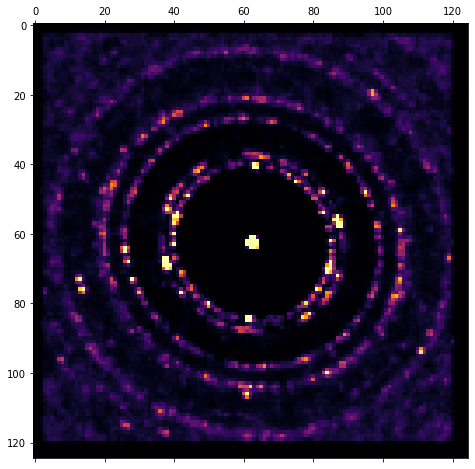

In [53]:
# Plot the Bragg vector map
py4DSTEM.visualize.show(
    bvm_cal,
    cmap='inferno',
    clipvals='manual',
    min=0,
    max=2500)

# Elliptical distortion calibration

Here we
- select an annular fitting region
- fit a 2D elliptical curve to this region of the BVM
- save the elliptical distortions to Coordinates
- correct the bragg disk positions by stretching along the semiminor axis until it matches the semimajor axis length
- check that the elliptical distortions have been removed from the corrected disk positions

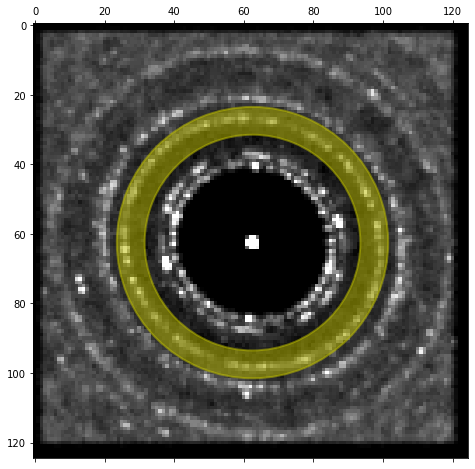

In [54]:
# Select fitting region
qrange = [31,39]
py4DSTEM.visualize.show(bvm_cal,cmap='gray',scaling='power',power=0.5,clipvals='manual',min=0,max=2500,
                        annulus={'center':(datacube.Q_Nx/2.,datacube.Q_Ny/2.),
                                 'Ri':qrange[0],'Ro':qrange[1],'fill':True,'color':'y','alpha':0.5})

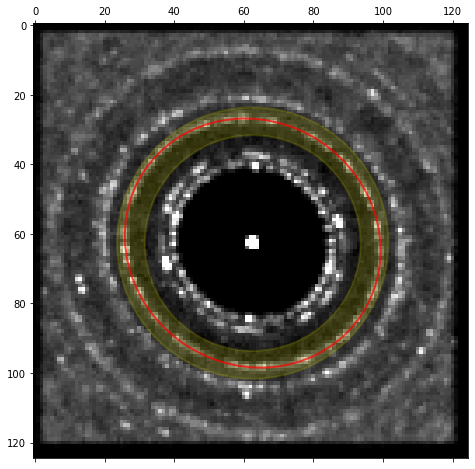

In [55]:
# Fit the elliptical distortions
qx0,qy0,a,e,theta = py4DSTEM.process.calibration.fit_ellipse_1D(
                        bvm_cal,(datacube.Q_Nx/2.,datacube.Q_Ny/2.),qrange)

py4DSTEM.visualize.show_elliptical_fit(
    bvm_cal,
    qrange,
    (qx0,qy0,a,e,theta),
    cmap='gray',
    scaling='power',
    power=0.5,clipvals='manual',
    min=0,
    max=2500,
    fill=True)

In [56]:
# Save to Coordinates
coordinates.set_ellipse(a,e,theta)

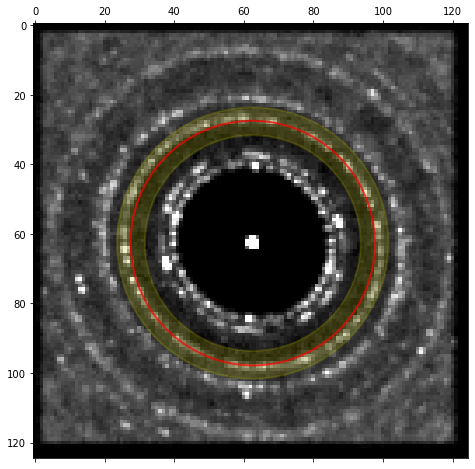

The ratio of the semiminor to semimajor axes was measured to be

	93.63% in the original data and
	99.56% in the corrected data.


In [57]:
# Confirm that elliptical distortions have been removed

# Correct bragg peak positions, stretching the elliptical semiminor axis to match the semimajor axis length
braggpeaks_ellipsecorr = py4DSTEM.process.calibration.correct_braggpeak_elliptical_distortions(
    braggpeaks_centered,
    (qx0,qy0,a,e,theta),
)

# Recompute the bvm
bvm_ellipsecorr = py4DSTEM.process.diskdetection.get_bragg_vector_map(
    braggpeaks_ellipsecorr,
    datacube.Q_Nx,
    datacube.Q_Ny)

# Fit an ellipse to the elliptically corrected bvm
qx0_corr,qy0_corr,a_corr,e_corr,theta_corr = py4DSTEM.process.calibration.fit_ellipse_1D(bvm_ellipsecorr,(qx0,qy0),qrange)

py4DSTEM.visualize.show_elliptical_fit(
    bvm_cal,
    qrange,
    (qx0_corr,qy0_corr,a_corr,e_corr,theta_corr),
    cmap='gray',
    scaling='power',
    power=0.5,clipvals='manual',
    min=0,
    max=2500,
    fill=True)


# py4DSTEM.visualize.show_elliptical_fit(bvm_ellipsecorr,center=(qx0_corr,qy0_corr),Ri=qmin,Ro=qmax,a=a_corr,e=e_corr,theta=theta_corr,fill=True,
#                                        cmap='gray',scaling='power',power=0.5,clipvals='manual',min=0,max=500)

# Print the ratio of the semi-axes before and after correction
print("The ratio of the semiminor to semimajor axes was measured to be")
print("")
print("\t{:.2f}% in the original data and".format(100*e/a))
print("\t{:.2f}% in the corrected data.".format(100*e_corr/a_corr))

# Pixel size calibration

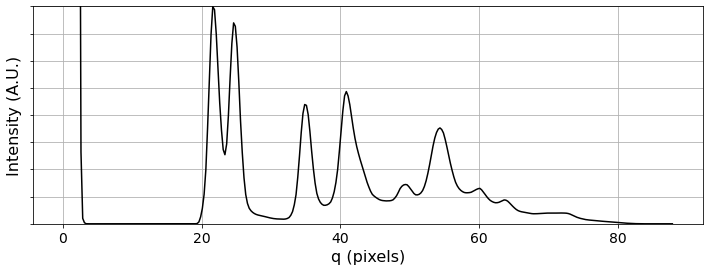

In [58]:
# Radial integration
ymax = 2.0e5
dq=0.25             # binsize for the x-axis

q,I_radial = py4DSTEM.process.utils.radial_integral(
                        bvm_ellipsecorr,datacube.Q_Nx/2,datacube.Q_Ny/2,dr=dq)
py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

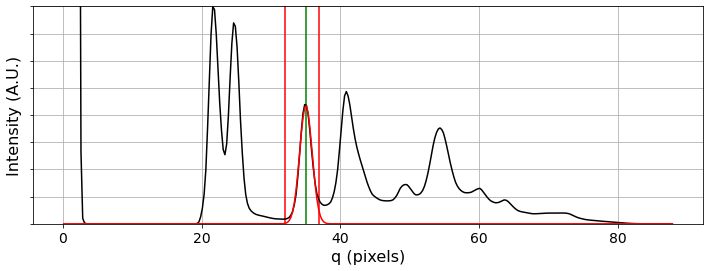

In [59]:
# Fit a gaussian to find a peak location
qmin,qmax = 32,37
A,mu,sigma = py4DSTEM.process.fit.fit_1D_gaussian(q,I_radial,qmin,qmax)

fig,ax = py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax,
                                          returnfig=True)
ax.vlines((qmin,qmax),0,ax.get_ylim()[1],color='r')
ax.vlines(mu,0,ax.get_ylim()[1],color='g')
ax.plot(q,py4DSTEM.process.fit.gaussian(q,A,mu,sigma),color='r')

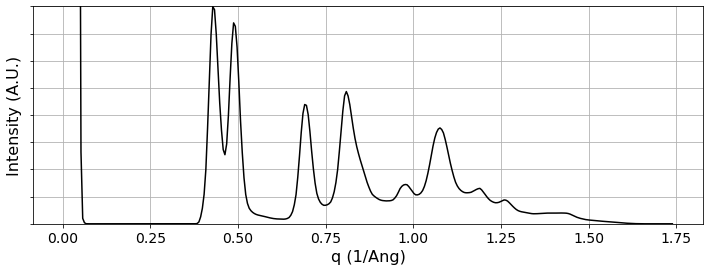

In [60]:
# Get pixel calibration
# At time of writing, one peak with a known spacing must be manually identified and entered
d_spacing_Ang = 1.442                           # This is the Au 022 peak
inv_Ang_per_pixel = 1./(d_spacing_Ang * mu)
py4DSTEM.visualize.show_qprofile(
    q=q*inv_Ang_per_pixel,
    intensity=I_radial,
    ymax=ymax,xlabel='q (1/Ang)')

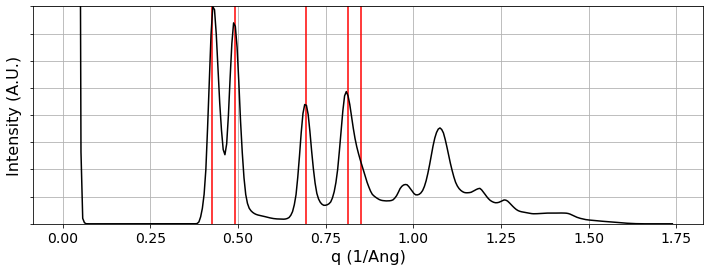

In [61]:
# Demonstrate consistency with known Au spacings
spacings_Ang = np.array([1.177,1.23,1.442,2.039,2.355])   # 222, 113, 022, 002, 111
spacings_inv_Ang = 1./spacings_Ang

fig,ax = py4DSTEM.visualize.show_qprofile(q=q*inv_Ang_per_pixel,intensity=I_radial,
                                 ymax=ymax,xlabel='q (1/Ang)',returnfig=True)
ax.vlines(spacings_inv_Ang,0,ax.get_ylim()[1],color='r')

In [62]:
# Store pixel size in coordinates object (ACOM currently hard assumes the units are Å^-1)
coordinates.set_Q_pixel_size(inv_Ang_per_pixel)
coordinates.set_Q_pixel_units(r'Å$^{-1}$')

In [63]:
bragg_peaks_calibrated = py4DSTEM.process.calibration.calibrate_Bragg_peaks_pixel_size(
    braggpeaks_ellipsecorr, coords=coordinates)

100%|███████████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 222155.93it/s]


# Rotation Calibration

Often the STEM probe scan coils are rotated with respect to the image direction.  It's best to calibrate this rotation using a shadow image in diffraction space. Alternatively, we can use DPC or pseudo-DPC rotation alignment.  Here we will use the shadow image method.

# Rotation Calibration from DPC

In [64]:
# Calculate the center of mass for all probe positions
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(datacube, mask=1)

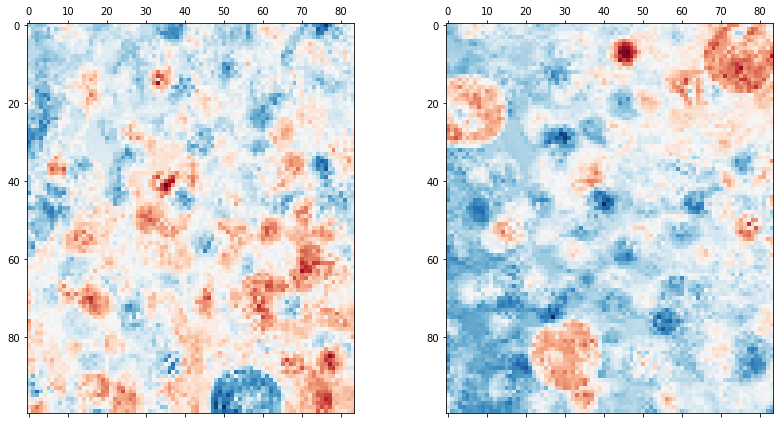

In [65]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

In [66]:
# Use one of the py4DSTEM DPC algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)

# Solve for minimum rotation from (-pi,pi) radian range
theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = theta*180/np.pi

# Print the results
print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

Analyzing: |**************************************************| 100.0% Complete.

Image flip detected = False
Best fit rotation =  86.2396 degrees


In [67]:
# Set rotation into the coordinates object
coordinates.set_QR_rotation(theta_deg * np.pi / 180)
coordinates.set_QR_flip(False)

In [68]:
# Generate final list of Bragg peaks
braggpeaks_rotated = py4DSTEM.process.calibration.calibrate_Bragg_peaks_rotation(bragg_peaks_calibrated,coords=coordinates)

100%|███████████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 102540.07it/s]


# Rotation Calibration from Shadow Images

In [69]:
# # Calculate a bright field image from the calibration scan.
# qx0,qy0 = 63.5,63.45
# qR = 12

# py4DSTEM.visualize.show(dp_max,scaling='log',
#                         circle={'center':(qx0,qy0),'R':qR,'alpha':.25,'fill':True})
# BF_rotation = py4DSTEM.process.virtualimage.get_virtualimage(datacube_rotation,qx0,qy0,qR)
# py4DSTEM.visualize.show(BF_rotation)

In [70]:
# # Show the shadow image and bright field scan image
# py4DSTEM.visualize.show(defocused_probe,figsize=(6,6))
# py4DSTEM.visualize.show(BF_rotation,figsize=(6,6))

In [71]:
# # Pick two fiducial points, locate them on each image
# cbed_p1 = (154,204)
# cbed_p2 = (212,401)
# stem_p1 = (59,16.5)
# stem_p2 = (15,37)

# import matplotlib.pyplot as plt

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
# ax1.matshow(defocused_probe,cmap='gray')
# ax2.matshow(BF_rotation,cmap='gray')
# ax1.plot((cbed_p1[1],cbed_p2[1]),(cbed_p1[0],cbed_p2[0]),color='y')
# ax1.scatter((cbed_p1[1],cbed_p2[1]),(cbed_p1[0],cbed_p2[0]),color=('r','b'))
# ax2.plot((stem_p1[1],stem_p2[1]),(stem_p1[0],stem_p2[0]),color='y')
# ax2.scatter((stem_p1[1],stem_p2[1]),(stem_p1[0],stem_p2[0]),color=('r','b'))
# ax1.grid(True)
# ax2.grid(True)

In [72]:
# # Measure the rotational offset
# stem_angle = np.angle(stem_p2[0]+1j*stem_p2[1] - stem_p1[0]-1j*stem_p1[1])%(2*np.pi)
# cbed_angle = np.angle(cbed_p2[0]+1j*cbed_p2[1] - cbed_p1[0]-1j*cbed_p1[1])%(2*np.pi)
# QR_rotation = stem_angle-cbed_angle
# print("Real space is rotated {} degrees counterclockwise with respect to diffraction space.".format(np.degrees(QR_rotation)))

In [73]:
# # Set rotation into the coordinates object
# coordinates.set_QR_rotation(QR_rotation)
# coordinates.set_QR_flip(False)

# Save and reload final Bragg peaks

This step makes it easier to resume the analysis midway through.

In [7]:
filepath_braggpeaks_rotated = 'braggpeaks_rotated.h5'

In [75]:
# Save Bragg disk positions
py4DSTEM.io.save(
    filepath_braggpeaks_rotated,
    braggpeaks_rotated,
    overwrite=True
)

Saving PointListArray 'braggpeaks_cal_centered_ellipsecorrected_calibrated_rotated'...


100%|█████████████████████████████████████████████████████████████████████████████| 8400/8400 [00:01<00:00, 6180.17it/s]


In [8]:
# Load Bragg disk positions
braggpeaks_rotated = py4DSTEM.io.read(
    filepath_braggpeaks_rotated, 
    data_id='braggpeaks_cal_centered_ellipsecorrected_calibrated_rotated')

Reading PointListArray: 100%|██████████████████████████████████████████████| 8400/8400 [00:01<00:00, 5424.70PointList/s]


In [9]:
# # Recompute the bvm
# im_size = [125, 125]
# bvm = py4DSTEM.process.diskdetection.get_bragg_vector_map(
#     braggpeaks_rotated,
#     im_size[0],
#     im_size[1])

In [10]:
# ymax = 2.0e5
# dq=0.25             # binsize for the x-axis
# inv_Ang_per_pixel = 0.0198

# q,I_radial = py4DSTEM.process.utils.radial_integral(
#     bvm,
#     im_size[0]/2,
#     im_size[1]/2,
#     dr=dq)
# py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

# Automated Crystal Orientation Mapping

First, we define our Crystal object. This can be done using:
* Manual entry of the lattice and basis
* By loading a CIF file
* By connecting to the Materials Project API (requires that an API key be set in the user's configuration file. See `crystal.py` documentation for details

In [11]:
# Define gold structure
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

crystal = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

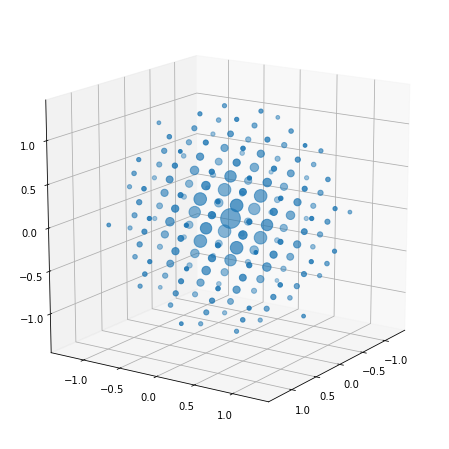

In [12]:
# Calculate and plot gold structure factors
k_max = 1.4

q_SF, I_SF = crystal.calculate_structure_factors(
    k_max, 
    return_intensities=True)

crystal.plot_structure_factors(
    proj_dir=[3, 2, 1],
    plot_limit=k_max,
)

In [15]:
# Compare the structure factors calculated from the structure to the calibrated diffraction intensity to confirm the pixel size calibration is correct

fig, ax = py4DSTEM.visualize.show_qprofile(
    q=q * inv_Ang_per_pixel,
    intensity=I_radial,
    ymax=ymax,
    xlabel="q (1/Ang)",
    returnfig=True,
)

ax.set_xlim([0.2, 1.5])
ax.plot(q_SF, I_SF * ymax * 0.7, c="r");

NameError: name 'q' is not defined

In [118]:
# Create an orientation plan for gold
crystal.orientation_plan(
    angle_step_zone_axis=2.0,
    angle_step_in_plane=4.0,
    # accel_voltage=300e3,
    # corr_kernel_size=0.08,
    intensity_power = 0.5,
    zone_axis_range='auto'
)

Automatically detected point group m-3m, using arguments: zone_axis_range=[[0 1 1]
 [1 1 1]], fiber_axis=None, fiber_angles=None.


Orientation plan: 100%|██████████████████████████████████████████████████████| 406/406 [00:01<00:00, 215.85 zone axes/s]


In [109]:
# Create an orientation plan for gold
crystal.orientation_plan(
    angle_step_zone_axis=2.0,
    angle_step_in_plane=4.0,
    # accel_voltage=300e3,
    # corr_kernel_size=0.08,
    intensity_power = 0.5,
)

Orientation plan: 100%|██████████████████████████████████████████████████████| 406/406 [00:01<00:00, 218.72 zone axes/s]


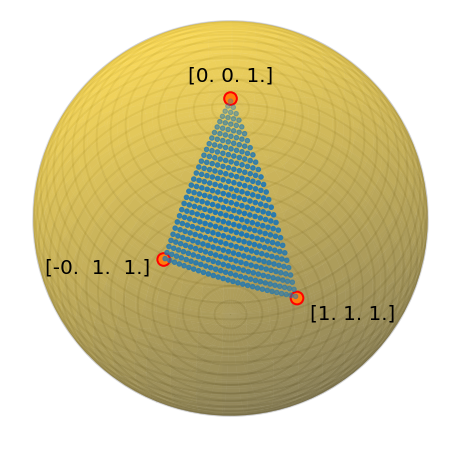

In [110]:
# Plot the zone axes included in the orientation plan
fig, ax = crystal.plot_orientation_zones(
    plot_limit=np.array([-0.6, 0.6]),
    returnfig=True)

Best fit zone axis = ([0.195 0.339 0.92 ]) with corr value = 11.054
Best fit zone axis = ([0.024 0.523 0.852]) with corr value = 5.275


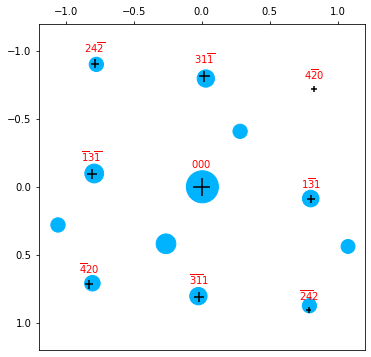

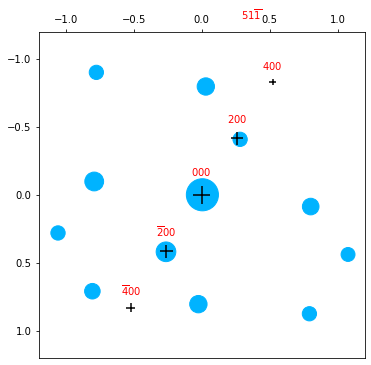

In [111]:
# Test matching on some probe positions
xind, yind = 40, 35
# xind, yind = 20, 5
# xind, yind = 52, 78


orientation = crystal.match_single_pattern(
    braggpeaks_rotated.pointlists[xind][yind],
    num_matches_return=2,
    plot_corr=False,
    verbose=True,
)
bragg_peaks_fit_0 = crystal.generate_diffraction_pattern(
    orientation, 
    ind_orientation=0,
    sigma_excitation_error=0.02
)
bragg_peaks_fit_1 = crystal.generate_diffraction_pattern(
    orientation, 
    ind_orientation=1,
    sigma_excitation_error=0.02
)

# plot comparison
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_0,
    bragg_peaks_compare=braggpeaks_rotated.pointlists[xind][yind],
    scale_markers_compare=50,
    plot_range_kx_ky=np.array([1.2, 1.2]),
    min_marker_size=0.001,
    figsize=(6, 6),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_1,
    bragg_peaks_compare=braggpeaks_rotated.pointlists[xind][yind],
    scale_markers_compare=50,
    plot_range_kx_ky=np.array([1.2, 1.2]),
    min_marker_size=0.001,
    figsize=(6, 6),
)

Based on these tests, we can return probably return only a single orientation per probe position.  Feel free to test finding 2 or more matches per probe position however.

In [112]:
# Fit orientation to all probe positions
orientation_map = crystal.match_orientations(
    braggpeaks_rotated,
    num_matches_return=1,
)

Matching Orientations: 100%|████████████████████████████████████████████████| 8400/8400 [02:25<00:00, 57.59 PointList/s]


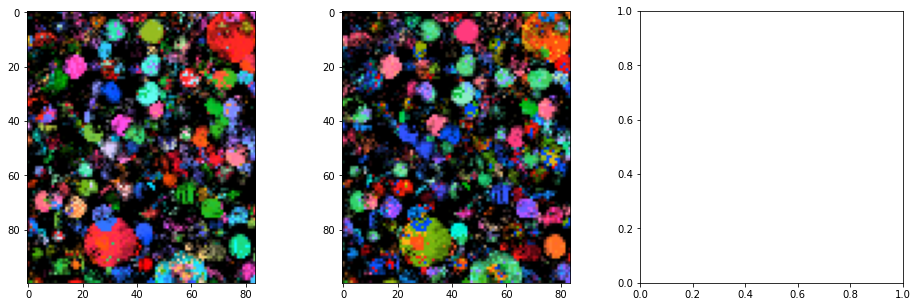

In [122]:
# plot orientation maps from all of the matches

# for a0 in range(orientation_map.num_matches):
crystal.plot_orientation_maps(
    orientation_map,
    ind_orientation=0,
    corr_range=np.array([6,10]),  # for correlation intensity power 0.5 (the default)
    corr_normalize=False,

#     scale_legend=np.array([0.45, 0.5]),
    returnfig=True,
    # figsize=(30,7)
)

In [104]:
# # plot orientation maps from one of the matches
# images_orientation, fig, ax = Au.plot_orientation_maps(
#     orientation_matrices,
#     corr_all,
#     orientation_index_plot=0,
#     corr_normalize=False,
#     corr_range=np.array([10, 12]),
#     scale_legend=np.array([0.45, 0.5]),
#     returnfig=True,
#     figsize=(30, 7),
# )

In [90]:
# Save the orientation map outputs
# fig.savefig('ACOM_Au_sim.pdf')